In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from scipy import stats

data_dir = "/scratch/new_courier_pilot/"
subject = 'R1620J'
exp = 'EFRCourierOpenLoop'
session = 3
reader = cml.CMLReader(subject, exp, 3)
evs = reader.load('task_events')
exp = 'EFRCourierOpenLoop'
whole_df = cml.CMLReader.get_data_index()
# Get unique subjects for the experiment
result_list = pd.DataFrame()
subjects = ['R1620J', 'R1653J', 'R1693J', 'R1709J', 'R1724J']
allstore=[]
# Initialize results storage
results = []
results_2 = []
Words_all = pd.DataFrame()
# Loop through each subject
for subject in subjects:
    # print(f"Processing subject: {subject}")
    
    # Get subject data
    sub_df = whole_df.query('experiment == @exp and subject == @subject')
    
    # Get all sessions for this subject
    sessions = sub_df['session'].unique()
    
    # Loop through each session
    for session in sessions:
        reader = cml.CMLReader(subject, exp, session=session)
        evs = reader.load('task_events')
        evs['inside_stimuli'] = -999
        stimuli_indices = evs[evs['type'] == 'STIM'].index

        for i in stimuli_indices:
            current_offset = evs.loc[i, 'eegoffset']
            evs.loc[i, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
            
            # Keep checking subsequent rows until difference >= 3000
            j = i + 1
            rows_to_assign = []  # Store indices of rows to assign

            while j < len(evs):
                next_offset = evs.loc[j, 'eegoffset']
                time_diff = abs(next_offset - current_offset)
                # print(time_diff)
                if time_diff < 3000:
                    # Still within 3 seconds, add this row to assignment list
                    rows_to_assign.append(j)
                    j += 1
                else:
                    # Found a row with difference >= 4000, stop checking
                    break

            # Assign burst_freq to all rows that were within 4000ms of the STIM
            for row_idx in rows_to_assign:
                evs.loc[row_idx, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
                evs.loc[i, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']

        # Get unique trials for this session
        trials = evs['trial'].unique()
        
        # Find indices of all WORD events
        word_indices = evs[evs['type'] == "WORD"].index

        # Get the events immediately before WORD events
        preceding_events = evs.iloc[word_indices - 1]

        # Find which preceding events are STIM type
        stim_mask = preceding_events['type'] == 'STIM'
        stim_indices = preceding_events[stim_mask].index

        # Update the inside_stimuli column for WORD events that follow STIM events
        for stim_idx in stim_indices:
            word_idx = stim_idx + 1
            burst_freq = evs.loc[stim_idx, 'stim_params']['burst_freq']
            evs.loc[word_idx, 'inside_stimuli'] = burst_freq
            evs.loc[stim_idx, 'inside_stimuli'] = burst_freq
            
        FirstTrial = evs[evs['trial'] == 1]
        pd.set_option('display.max_rows', None)
        FirstTrial[['store', 'type']]
        trials=evs['trial'].unique()
        trials = [x for x in trials if x != -999]
        for trial in trials:
            evs_trial=evs[evs['trial'] == trial]
            pointingfinish = evs_trial[evs_trial['type'] == 'pointing finished']
            pointingfinish = pointingfinish.reset_index(drop=True)
            pointingfinish = pointingfinish.iloc[0:-1].reset_index(drop=True)
            Words = evs_trial[evs_trial['type'] == 'WORD']
            Words = Words.reset_index(drop=True)
            pointingfinish['arrival'] = Words['mstime']
            pointingfinish['store']=Words['store']
            pointingfinish['condition']=Words['inside_stimuli']
            Words_all = Words_all.append(pointingfinish)
            # Get unique stores (add parentheses to call the method)
        allstore = Words_all['store'].unique()

    # Initialize empty list to collect results


        for store in allstore:
            # Filter data for current store
            new_words = Words_all[Words_all['store'] == store]

            # Loop through rows
            for i in range(len(new_words)):
               
                result = {
                    'store': new_words.iloc[i]['store'],
                    # Fix time calculation
                    'time': new_words.iloc[i]['arrival'] - new_words.iloc[i]['mstime'],  
                    # Fix column reference
                    'condition': new_words.iloc[i]['condition'],
                    'visit_time': i,
                    'trial': new_words.iloc[i]['trial'],
                    'session': new_words.iloc[i]['session'],
                    'subject': new_words.iloc[i]['subject']  # Fixed: was overwriting 'session'
                }
                result_list = result_list.append(result, ignore_index=True)

        # Convert to DataFrame at the end (more efficient than repeated append)
    result_pd = pd.DataFrame(result_list)

In [25]:
what=result_pd.groupby(['subject','visit_time','session']).mean()
what

time   condition     trial
subject visit_time session                                    
R1620J  0.0        3.0      17637.176471 -526.882353  0.352941
        1.0        3.0      19165.000000 -525.705882  1.764706
        2.0        3.0      19174.214286 -568.857143  2.857143
                   4.0      13064.333333 -331.000000  0.666667
        3.0        3.0      16511.777778 -552.555556  3.555556
                   4.0      24707.000000 -496.125000  0.875000
        4.0        3.0      15755.333333 -665.000000  4.000000
                   4.0      19633.571429 -497.285714  1.428571
        5.0        4.0      17382.428571 -568.500000  1.785714
        6.0        4.0      21380.153846 -612.846154  3.153846
        7.0        4.0      19359.000000 -496.750000  2.750000
        8.0        4.0      17862.000000 -329.333333  3.333333
        9.0        4.0      16823.000000    3.000000  4.000000
R1653J  5.0        0.0      21137.666667 -331.000000  0.000000
        6.0        0.0      19862.250000 -245.000000  0.750000
        7.0        0.0      17794.307692 -535.769231  1.076923
        8.0        0.0      22186.272727 -542.181818  2.000000
                   1.0      22433.000000 -329.333333  0.666667
        9.0        0.0      26272.142857 -567.428571  1.857143
                   1.0      18301.666667 -552.555556  1.000000
        10.0       0.0      22829.200000 -598.200000  1.600000
                   1.0      17794.750000 -496.333333  1.500000
        11.0       0.0      14767.333333 -663.333333  2.333333
                   1.0      15649.692308 -535.384615  2.000000
                   2.0      17133.000000    3.000000  0.000000
        12.0       0.0      17217.000000    3.000000  2.000000
                   1.0      22392.363636 -541.727273  2.909091
                   2.0      25982.400000 -597.200000  0.800000
        13.0       0.0      34446.000000    8.000000  3.000000
                   1.0      20188.750000 -748.500000  3.000000
                   2.0      20379.272727 -543.090909  1.000000
        14.0       1.0      29850.250000 -495.500000  2.750000
                   2.0      22687.800000 -495.500000  1.900000
        15.0       1.0      11481.000000    3.000000  1.000000
                   2.0      20845.363636 -543.090909  2.181818
        16.0       1.0      31858.000000    8.000000  2.000000
                   2.0      23377.125000 -497.375000  2.750000
        17.0       1.0      11167.000000    3.000000  3.000000
                   2.0      20509.000000 -597.200000  3.000000
        18.0       1.0      13476.000000    8.000000  4.000000
                   2.0      15430.000000 -665.000000  3.666667
        19.0       2.0      22991.000000 -498.000000  2.000000
        20.0       2.0      28352.000000    8.000000  1.000000
        21.0       2.0      15818.000000    3.000000  2.000000
        22.0       2.0      27688.000000    8.000000  3.000000
        23.0       2.0      17778.000000    3.000000  4.000000
R1693J  13.0       0.0      17790.000000 -999.000000  0.000000
        14.0       0.0      22243.500000 -495.500000  0.500000
                   1.0      17089.000000 -999.000000  1.000000
        15.0       0.0      28776.500000 -245.000000  0.750000
        16.0       0.0      40020.400000 -597.200000  0.600000
                   1.0      19892.000000 -495.500000  1.000000
        17.0       0.0      39382.714286 -568.142857  1.142857
                   1.0      12337.000000    3.000000  0.000000
        18.0       0.0      32117.600000 -999.000000  1.400000
                   1.0      29510.000000 -247.500000  0.000000
        19.0       0.0      38087.250000 -495.500000  0.750000
                   1.0      27634.333333 -663.333333  0.500000
        20.0       0.0      22229.750000 -246.250000  1.000000
                   1.0      21277.000000 -999.000000  0.500000
        21.0       0.0      32202.666667    6.333333  1.666667
                   1.0      19523.500000 -999.000000  1.000000
    

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from scipy import stats

data_dir = "/scratch/new_courier_pilot/"
exp = 'EFRCourierOpenLoop'
whole_df = cml.CMLReader.get_data_index()

# Get unique subjects for the experiment
subjects = ['R1620J', 'R1653J', 'R1693J', 'R1709J', 'R1724J']

# Initialize results storage OUTSIDE all loops
result_list = pd.DataFrame()
Words_all = pd.DataFrame()

# Loop through each subject
for subject in subjects:
    print(f"Processing subject: {subject}")
    
    # Get subject data
    sub_df = whole_df.query('experiment == @exp and subject == @subject')
    
    # Get all sessions for this subject
    sessions = sub_df['session'].unique()
    Words_all = pd.DataFrame()
    # Loop through each session
    for session in sessions:
        print(f"  Processing session: {session}")
        
        reader = cml.CMLReader(subject, exp, session=session)
        evs = reader.load('task_events')
        evs['inside_stimuli'] = -999
        
        # Process stimuli
        stimuli_indices = evs[evs['type'] == 'STIM'].index
        for i in stimuli_indices:
            current_offset = evs.loc[i, 'eegoffset']
            evs.loc[i, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
            
            # Keep checking subsequent rows until difference >= 3000
            j = i + 1
            rows_to_assign = []
            
            while j < len(evs):
                next_offset = evs.loc[j, 'eegoffset']
                time_diff = abs(next_offset - current_offset)
                if time_diff < 3000:
                    rows_to_assign.append(j)
                    j += 1
                else:
                    break
            
            # Assign burst_freq to all rows that were within 3000ms of the STIM
            for row_idx in rows_to_assign:
                evs.loc[row_idx, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
        
        # Process WORD events that follow STIM events
        word_indices = evs[evs['type'] == "WORD"].index
        preceding_events = evs.iloc[word_indices - 1]
        stim_mask = preceding_events['type'] == 'STIM'
        stim_indices = preceding_events[stim_mask].index
        
        for stim_idx in stim_indices:
            word_idx = stim_idx + 1
            burst_freq = evs.loc[stim_idx, 'stim_params']['burst_freq']
            evs.loc[word_idx, 'inside_stimuli'] = burst_freq
            evs.loc[stim_idx, 'inside_stimuli'] = burst_freq
        
        # Process trials
        trials = evs['trial'].unique()
        trials = [x for x in trials if x != -999]
        
        for trial in trials:
            evs_trial = evs[evs['trial'] == trial]
            pointingfinish = evs_trial[evs_trial['type'] == 'pointing finished']
            
            if len(pointingfinish) == 0:
                continue  # Skip if no pointing finished events
                
            pointingfinish = pointingfinish.reset_index(drop=True)
            pointingfinish = pointingfinish.iloc[0:-1].reset_index(drop=True)
            
            Words = evs_trial[evs_trial['type'] == 'WORD']
            Words = Words.reset_index(drop=True)
            
            # Make sure we have matching lengths
            min_len = min(len(pointingfinish), len(Words))
            if min_len == 0:
                continue
                
            pointingfinish = pointingfinish.iloc[:min_len]
            Words = Words.iloc[:min_len]
            
            pointingfinish['arrival'] = Words['mstime'].values
            pointingfinish['store'] = Words['store'].values
            pointingfinish['condition'] = Words['inside_stimuli'].values
            
            # Use pd.concat instead of deprecated append
            Words_all = pd.concat([Words_all, pointingfinish], ignore_index=True)

# Process all collected data AFTER collecting from all subjects/sessions
        if not Words_all.empty:
            allstore = Words_all['store'].unique()

        for store in allstore:
            # Filter data for current store
            new_words = Words_all[Words_all['store'] == store].reset_index(drop=True)

            # Loop through rows for this store
            for i in range(len(new_words)):
                result = {
                    'store': new_words.iloc[i]['store'],
                    'time': new_words.iloc[i]['arrival'] - new_words.iloc[i]['mstime'],
                    'condition': new_words.iloc[i]['condition'],
                    'visit_time': i,
                    'trial': new_words.iloc[i]['trial'],
                    'session': new_words.iloc[i]['session'],
                    'subject': new_words.iloc[i]['subject'],
                    'last_condition':new_words.iloc[i-1]['condition'] if i>1 else 0
                }
                # Use pd.concat instead of deprecated append
                result_list = pd.concat([result_list, pd.DataFrame([result])], ignore_index=True)

# Final result
result_pd = result_list
print(f"Final result shape: {result_pd.shape}")
print(result_pd.head())

Processing subject: R1620J
  Processing session: 3
  Processing session: 4
Processing subject: R1653J
  Processing session: 0
  Processing session: 1
  Processing session: 2
Processing subject: R1693J
  Processing session: 0
  Processing session: 1
Processing subject: R1709J
  Processing session: 0
  Processing session: 1
Processing subject: R1724J
  Processing session: 0
Final result shape: (775, 8)
      store   time  condition  visit_time  trial  session subject  \
0  pharmacy  20471          3           0      0        3  R1620J   
1  pharmacy   9000          8           1      1        3  R1620J   
2  pharmacy  14851          3           2      2        3  R1620J   
3  pharmacy  14022          8           3      3        3  R1620J   
4  pharmacy  13641          3           4      4        3  R1620J   

   last_condition  
0               0  
1               0  
2               8  
3               3  
4               8  


In [39]:
result_pd.groupby(['subject','store','condition']).mean()

time  visit_time     trial   session
subject store          condition                                              
R1620J  bakery          3         13094.000000    4.000000  2.000000  4.000000
                        8         14293.000000    1.666667  2.000000  3.333333
        barber_shop     3         29481.333333    2.666667  4.000000  3.333333
                        8         29607.000000    1.000000  1.800000  3.200000
        bike_shop      -999       19419.000000    2.444444  1.555556  3.555556
        cafe           -999       22195.700000    2.400000  1.700000  3.400000
        clothing_store -999       21205.000000    2.400000  2.200000  3.400000
        craft_shop      3         17603.400000    2.000000  1.600000  3.200000
                        8         17004.000000    2.833333  2.000000  3.333333
        dentist        -999       19502.333333    2.583333  2.000000  3.166667
        florist        -999       17830.125000    1.625000  1.750000  3.250000
        grocery_store   3         19716.000000    2.888889  2.000000  3.333333
                        8         23220.500000    4.000000  2.500000  3.500000
        gym             3         17071.333333    2.500000  1.666667  3.333333
                        8         15901.500000    1.500000  2.000000  3.000000
        hardware_store -999       17732.818182    2.454545  2.454545  3.272727
        jewelry_store  -999       18716.818182    2.454545  1.818182  3.272727
        music_store    -999       15635.357143    3.285714  1.857143  3.285714
        pet_store       3         20851.000000    1.333333  3.000000  3.333333
                        8         15642.000000    3.000000  3.000000  4.000000
        pharmacy        3         16028.666667    3.666667  2.000000  3.333333
                        8         12731.166667    3.666667  2.000000  3.333333
        pizzeria       -999       14867.000000    2.833333  2.333333  3.333333
        toy_store       3         24972.500000    2.000000  1.000000  3.333333
                        8         19479.000000    3.000000  1.500000  3.500000
R1653J  bakery         -999       22817.857143    2.285714  1.928571  0.714286
        barber_shop     3         20244.090909    3.636364  1.636364  0.545455
                        8         14642.583333    4.083333  1.666667  0.666667
        bike_shop      -999       19382.823529    2.647059  1.823529  0.470588
        cafe            3         20940.400000    5.100000  2.000000  1.000000
                        8         21577.153846    3.538462  2.076923  0.615385
        clothing_store -999       20286.176471    3.058824  1.823529  0.823529
        craft_shop     -999       26998.150000    3.300000  1.800000  0.600000
        dentist         3         19505.500000    3.875000  1.000000  1.000000
                        8         14771.727273    2.909091  1.545455  0.545455
        florist        -999       17537.400000    3.450000  1.700000  0.700000
        grocery_store  -999       26241.550000    3.650000  1.600000  0.800000
        gym             3         20209.636364    2.000000  1.454545  0.545455
                        8         14429.833333    5.000000  2.666667  1.333333
        hardware_store -999       18754.947368    3.736842  1.578947  0.947368
        jewelry_store  -999       16042.250000    2.937500  1.500000  0.875000
        music_store    -999       19102.157895    3.315789  2.263158  0.736842
        pet_store       3         21925.916667    3.750000  1.500000  0.666667
                        8         18999.166667    4.583333  2.333333  0.666667
        pharmacy        3         16610.692308    4.846154  1.538462  0.769231
                        8         26979.928571    5.000000  2.000000  0.714286
        pizzeria        3         13496.111111    3.000000  1.333333  0.666667
                        8         29530.777778    3.444444  1.666667  0.888889
        toy_store       3         14076.250000    3.250000  2.000000  1.500000
             

In [40]:
result_pd
new=result_pd.groupby(['condition','visit_time']).mean()
new_err=result_pd.groupby(['condition','visit_time']).sem()

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

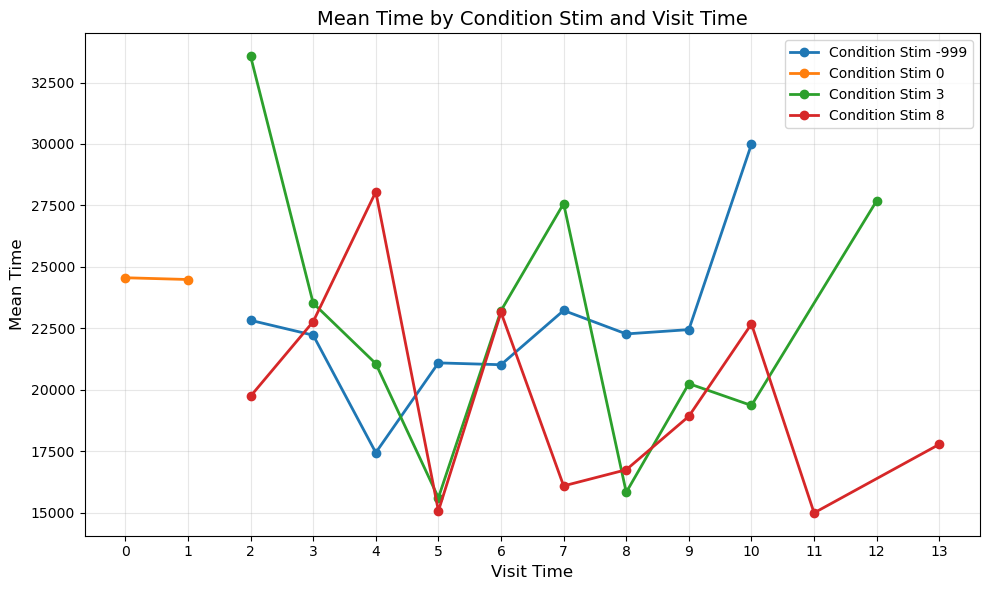

In [50]:
result_pd
new=result_pd.groupby(['last_condition','visit_time']).mean()
new_err=result_pd.groupby(['last_condition','visit_time']).sem()
plt.figure(figsize=(10, 6))

# Get unique condition_Stim values
condition_stim_values = new.index.get_level_values('last_condition').unique()

# Plot each condition_Stim as a different line
for condition in condition_stim_values:
    # Filter data for this condition
    condition_data = new.loc[condition]
    
    # Get visit_time values (x-axis) and the values to plot (y-axis)
    visit_times = condition_data.index  # visit_time values
    
    # Choose which column to plot - adjust this based on your data
    # For example, if you want to plot a specific column:
    y_values = condition_data.iloc[:, 0]  # plots first column, or specify column name
    
    # Plot the line
    plt.plot(visit_times, y_values, marker='o', label=f'Condition Stim {condition}', linewidth=2, markersize=6)

# Customize the plot
plt.xlabel('Visit Time', fontsize=12)
plt.ylabel('Mean Time', fontsize=12)
plt.title('Mean Time by Condition Stim and Visit Time', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(int(new.index.get_level_values('visit_time').min()), 
                 int(new.index.get_level_values('visit_time').max()) + 1))

# Show the plot
plt.tight_layout()
plt.show()

In [90]:
result_pd
new=result_pd.groupby(['last_condition','visit_time']).mean()
new_err=result_pd.groupby(['last_condition','visit_time']).sem()
new=result_pd.groupby(['store','subject']).mean()

In [ ]:
result_pd

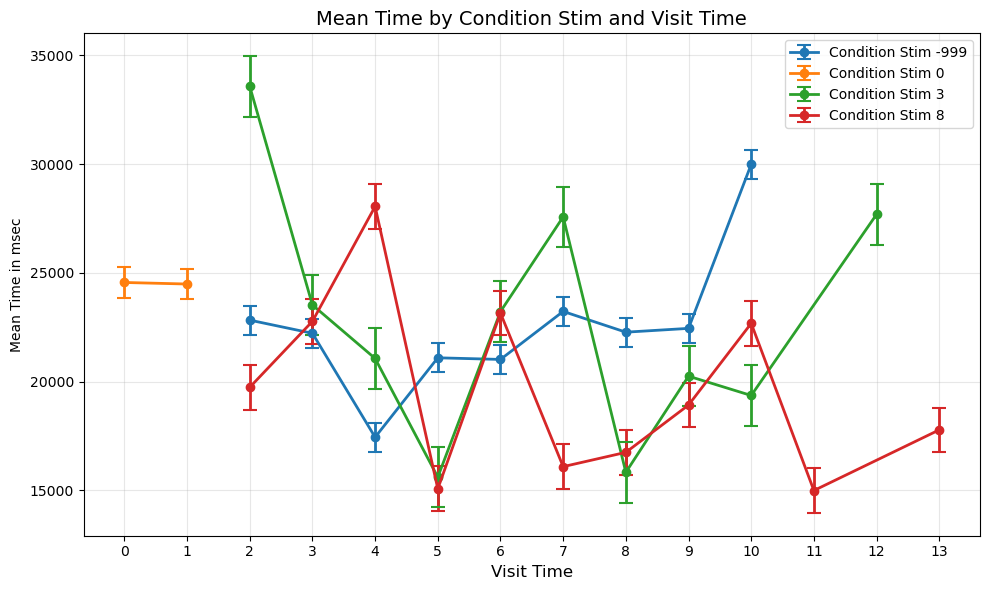

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate both mean and standard error
new=result_pd.groupby(['last_condition','visit_time']).mean()
new_err=result_pd.groupby(['last_condition','visit_time']).sem()

# Create the plot
plt.figure(figsize=(10, 6))

# Get unique condition_Stim values
condition_stim_values = new.index.get_level_values('last_condition').unique()

# Plot each condition_Stim as a different line with error bars
for condition in condition_stim_values:
    # Filter data for this condition
    condition_data = new.loc[condition]
    condition_se_data = new_se.loc[condition]
    
    # Get visit_time values (x-axis) and the values to plot (y-axis)
    visit_times = condition_data.index  # visit_time values
    
    # Plot only the 'time' column
    y_values = condition_data['time']
    error_values = condition_se_data['time']
    
    # Plot the line with error bars
    plt.errorbar(visit_times, y_values, yerr=error_values, marker='o', 
                label=f'Condition Stim {condition}', linewidth=2, markersize=6,
                capsize=5, capthick=1.5)

# Customize the plot
plt.xlabel('Visit Time', fontsize=12)
plt.ylabel('Mean Time in msec')
plt.title('Mean Time by Condition Stim and Visit Time', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(int(new.index.get_level_values('visit_time').min()), 
                 int(new.index.get_level_values('visit_time').max()) + 1))

# Show the plot
plt.tight_layout()
plt.show()

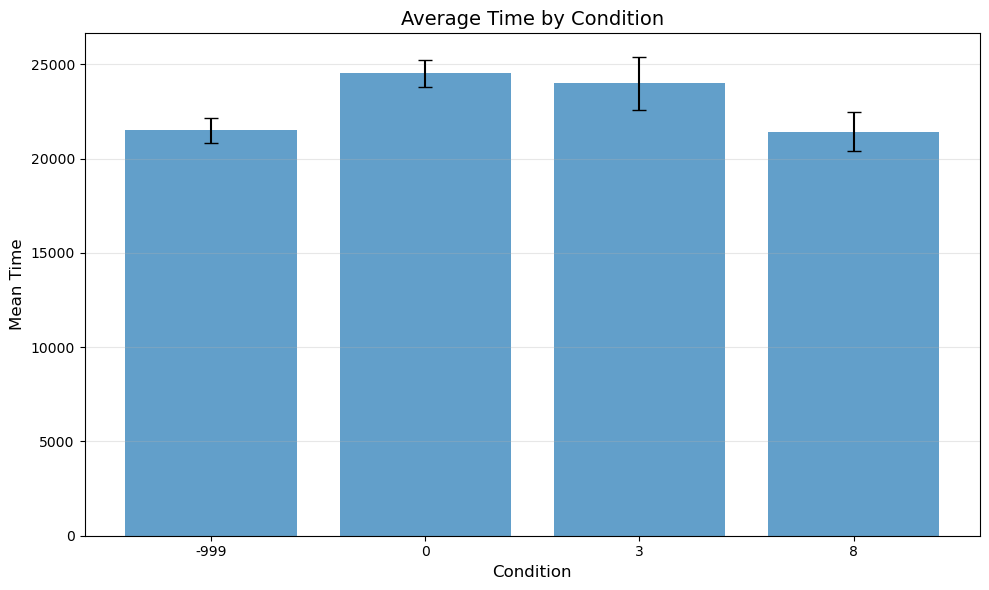

In [64]:
import matplotlib.pyplot as plt

# Group by condition only to get averages for each condition (averaged over visit_time)
new = result_pd.groupby(["last_condition"]).mean()
new_se = result_pd.groupby(["last_condition"]).sem()

# Create the plot
plt.figure(figsize=(10, 6))

# Get unique condition values
condition_values = new.index

# Create x-axis positions for the bars
x_positions = range(len(condition_values))

# Plot as a bar chart with error bars
plt.bar(x_positions, new['time'], yerr=new_se['time'], 
        capsize=5, alpha=0.7)

# Set x-axis labels
plt.xticks(x_positions, condition_values)

# Customize the plot
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Mean Time', fontsize=12)
plt.title('Average Time by Condition', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Show the plot
plt.tight_layout()
plt.show()

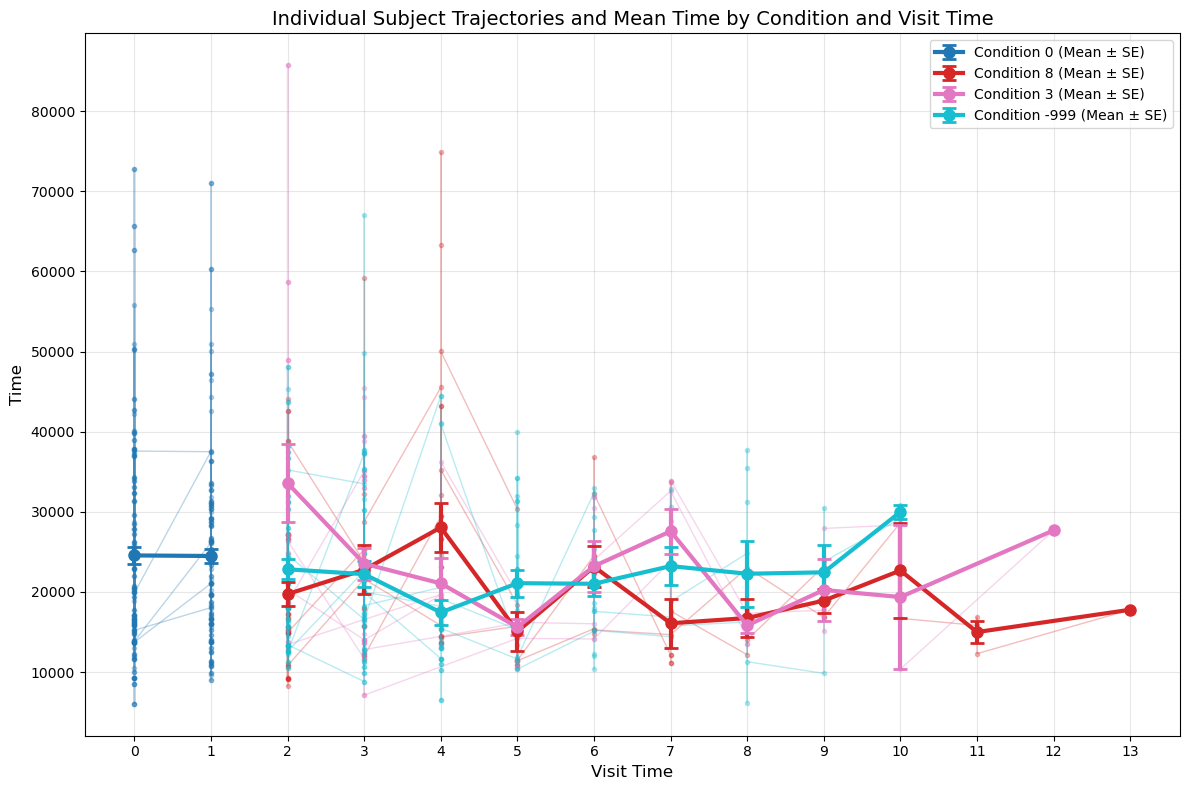


Summary Statistics:
Number of subjects per condition:
  Condition 0: 0 subjects
  Condition 8: 5 subjects
  Condition 3: 5 subjects
  Condition -999: 5 subjects

Visit times: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Total observations: 775


In [66]:
# Calculate mean across subjects (not including subject in groupby)
condition_means = result_pd.groupby(["last_condition", "visit_time"]).mean()
condition_se = result_pd.groupby(["last_condition", "visit_time"]).sem()

# Create the plot
plt.figure(figsize=(12, 8))

# Get unique condition values
condition_values = result_pd['last_condition'].unique()

# Define colors for conditions
colors = plt.cm.tab10(np.linspace(0, 1, len(condition_values)))

# Plot each condition
for i, condition in enumerate(condition_values):
    condition_color = colors[i]
    
    # Filter data for this condition
    condition_data = result_pd[result_pd['last_condition'] == condition]
    
    # Get unique subjects for this condition
    subjects = condition_data['subject'].unique()
    
    # Plot individual subject trajectories (thin, semi-transparent lines)
    for subject in subjects:
        subject_data = condition_data[condition_data['subject'] == subject]
        subject_data_sorted = subject_data.sort_values('visit_time')
        
        plt.plot(subject_data_sorted['visit_time'], subject_data_sorted['time'], 
                color=condition_color, alpha=0.3, linewidth=1, 
                marker='o', markersize=3)
    
    # Plot the mean line with error bars (thick, opaque line)
    mean_data = condition_means.loc[condition]
    se_data = condition_se.loc[condition]
    
    visit_times = mean_data.index  # visit_time values
    y_values = mean_data['time']
    error_values = se_data['time']
    
    plt.errorbar(visit_times, y_values, yerr=error_values, 
                color=condition_color, marker='o', linewidth=3, markersize=8,
                capsize=5, capthick=2, label=f'Condition {condition} (Mean ± SE)',
                zorder=10)  # Higher zorder to plot on top

# Customize the plot
plt.xlabel('Visit Time', fontsize=12)
plt.ylabel('Time', fontsize=12)
plt.title('Individual Subject Trajectories and Mean Time by Condition and Visit Time', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Set x-axis ticks
visit_time_range = result_pd['visit_time'].unique()
plt.xticks(sorted(visit_time_range))

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print("\nSummary Statistics:")
print("Number of subjects per condition:")
for condition in condition_values:
    n_subjects = len(result_pd[result_pd['condition'] == condition]['subject'].unique())
    print(f"  Condition {condition}: {n_subjects} subjects")

print(f"\nVisit times: {sorted(visit_time_range)}")
print(f"Total observations: {len(result_pd)}")

In [111]:
result_pd.groupby(["condition", "visit_time",'subject']).mean()

time     trial   session
condition visit_time subject                                  
-999.0    0.0        R1620J   15478.000000  0.222222  3.000000
          1.0        R1620J   20106.000000  1.555556  3.000000
          2.0        R1620J   18843.123596  2.696629  3.101124
          3.0        R1620J   19375.965116  2.302326  3.418605
          4.0        R1620J   16200.337349  1.831325  3.759036
          5.0        R1620J   17898.250000  1.750000  4.000000
                     R1653J    9304.000000  0.000000  0.000000
          6.0        R1620J   24054.625000  3.375000  4.000000
                     R1653J   29071.000000  1.000000  0.000000
          7.0        R1620J   15080.500000  3.000000  4.000000
                     R1653J   14239.428571  0.571429  0.000000
          8.0        R1620J   16253.000000  3.000000  4.000000
                     R1653J   26054.709091  2.018182  0.127273
          9.0        R1653J   24269.104478  1.029851  0.522388
          10.0       R1653J   21264.045455  1.575758  0.636364
          11.0       R1653J   12896.600000  2.353846  0.753846
          12.0       R1653J   23690.450000  2.083333  1.300000
          13.0       R1653J   19419.561404  1.947368  1.631579
                     R1693J   17790.000000  0.000000  0.000000
          14.0       R1653J   24920.295455  2.477273  1.681818
                     R1693J   23354.555556  1.000000  0.444444
          15.0       R1653J   20664.333333  2.166667  2.000000
                     R1693J   11301.000000  2.000000  0.000000
                     R1709J   37887.000000  0.000000  0.000000
          16.0       R1653J   26801.000000  2.250000  2.000000
                     R1693J   26948.000000  0.210526  0.210526
                     R1709J   17156.000000  2.000000  0.000000
          17.0       R1653J   24459.666667  2.666667  2.000000
                     R1693J   44515.750000  0.750000  0.000000
                     R1709J   19642.000000  1.000000  0.000000
          18.0       R1653J   16998.500000  3.500000  2.000000
                     R1693J   31084.827586  1.206897  0.137931
                     R1709J   25989.333333  1.333333  0.000000
                     R1724J   50920.000000  1.000000  0.000000
          19.0       R1653J   29127.000000  4.000000  2.000000
                     R1693J   37836.884615  0.730769  0.615385
                     R1709J   13109.285714  0.857143  0.571429
                     R1724J   42598.000000  2.000000  0.000000
          20.0       R1693J   27218.923077  1.076923  0.615385
                     R1709J   38072.750000  1.750000  0.250000
          21.0       R1693J   19523.500000  1.000000  1.000000
                     R1709J   32492.600000  1.200000  0.400000
                     R1724J   24506.000000  2.000000  0.000000
          22.0       R1709J   29028.909091  1.272727  0.181818
                     R1724J   16859.000000  3.000000  0.000000
          23.0       R1709J   25069.250000  1.125000  0.250000
                     R1724J   19402.000000  0.000000  0.000000
          24.0       R1693J   50197.000000  0.000000  1.000000
                     R1709J   37052.750000  2.125000  0.250000
          25.0       R1709J   26574.000000  1.384615  0.307692
                     R1724J   41031.500000  0.500000  0.000000
          26.0       R1709J   25462.400000  1.700000  0.400000
                     R1724J   42942.000000  1.000000  0.000000
          27.0       R1709J   30724.000000  0.000000  1.000000
                     R1724J   23002.500000  1.000000  0.000000
          28.0       R1709J   16696.500000  1.000000  1.000000
                     R1724J   21212.666667  2.333333  0.000000
          29.0       R1709J   17231.000000  2.000000  1.000000
                     R1724J   19504.333333  2.000000  0.000000
          30.0       R1724J   20269.000000  1.000000  0.000000
          31.0       R1724J   18999.000000  2.000000  0.000000
          32.0       R1724J   16846.000000  3.000000  0.000000
 3.0  

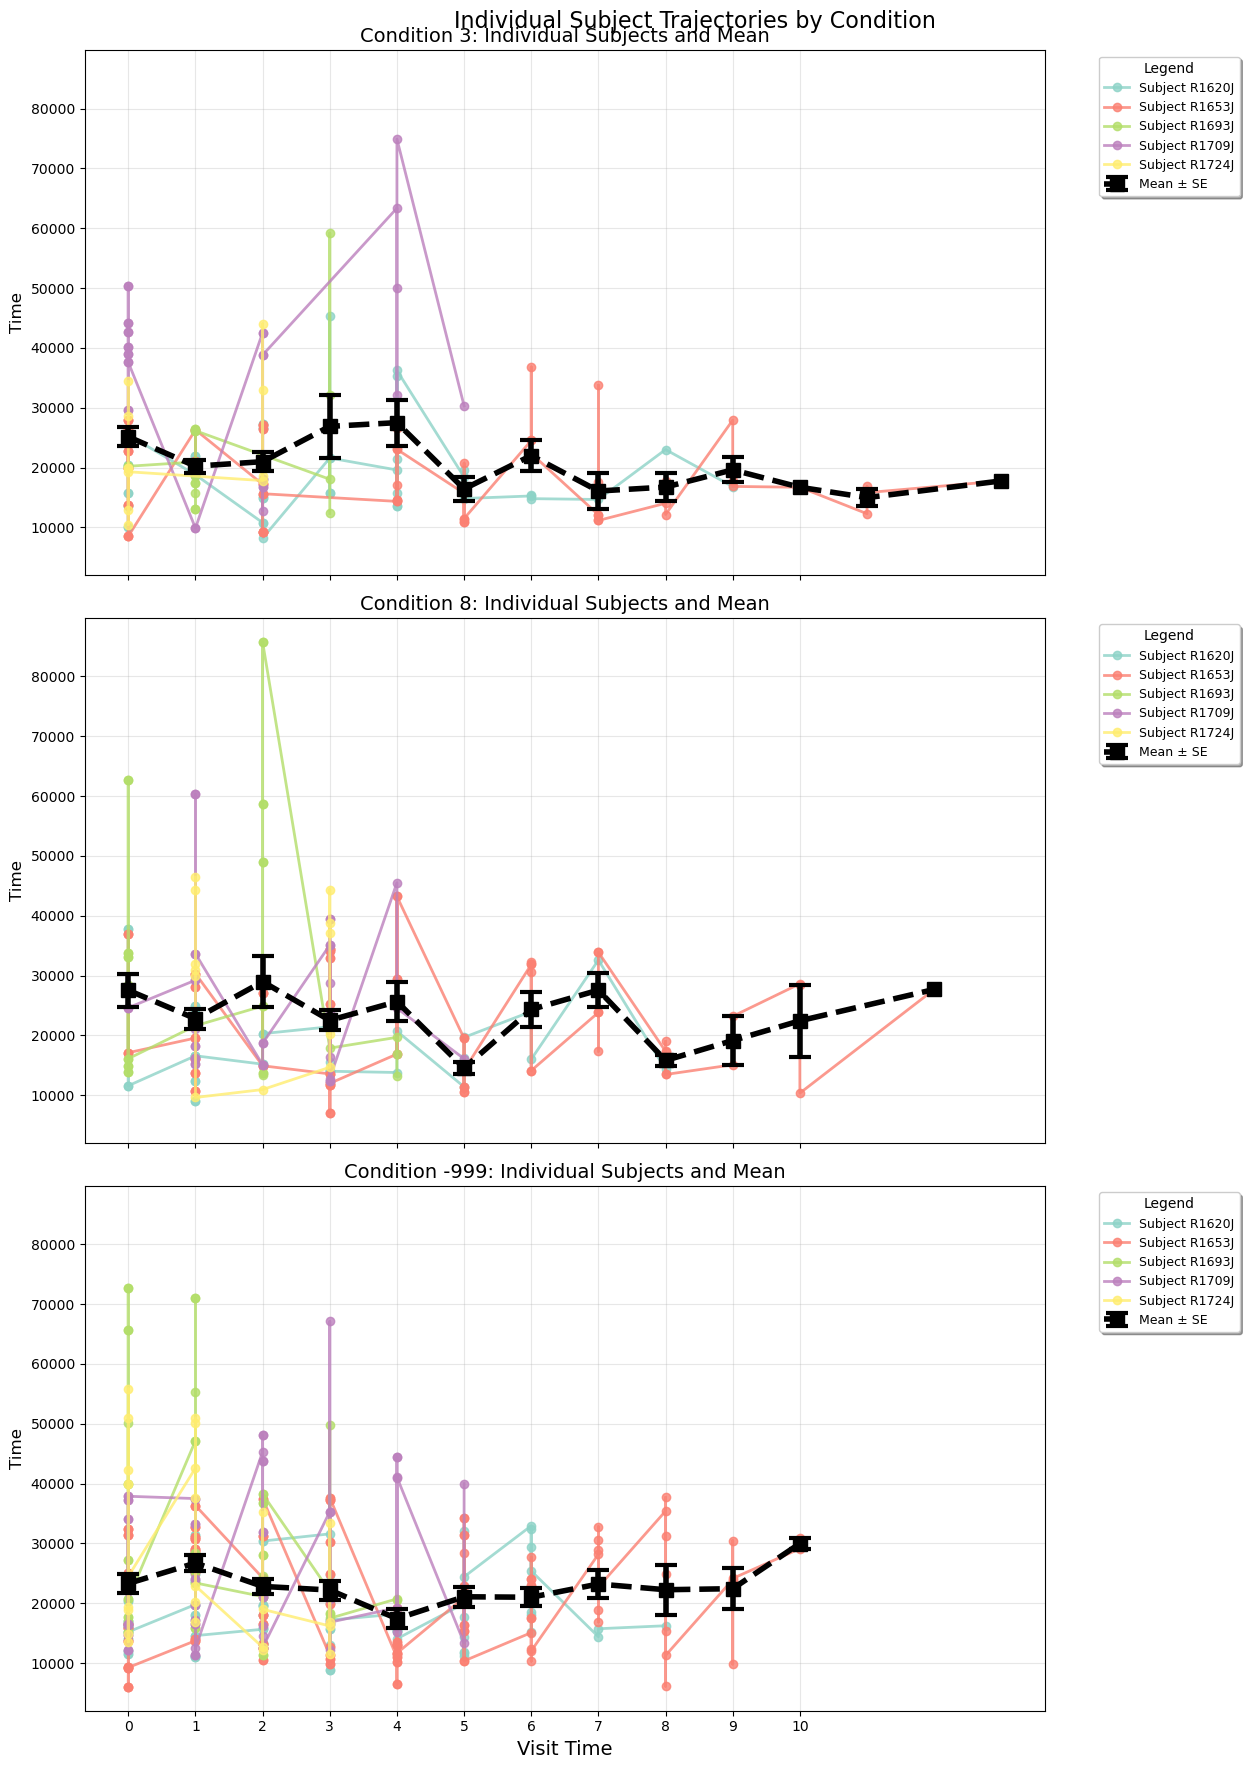


Summary Statistics:
Number of subjects per condition:
  Condition 3: 5 subjects
    Subjects: ['R1620J', 'R1653J', 'R1693J', 'R1709J', 'R1724J']
  Condition 8: 5 subjects
    Subjects: ['R1620J', 'R1653J', 'R1693J', 'R1709J', 'R1724J']
  Condition -999: 5 subjects
    Subjects: ['R1620J', 'R1653J', 'R1693J', 'R1709J', 'R1724J']

Visit times: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Total observations: 775
Total unique subjects: 5

Subject Color Mapping:


In [67]:
# Calculate mean across subjects (not including subject in groupby)
condition_means = result_pd.groupby(["condition", "visit_time"]).mean()
condition_se = result_pd.groupby(["condition", "visit_time"]).sem()

# Get unique condition and subject values
condition_values = result_pd['condition'].unique()
all_subjects = result_pd['subject'].unique()

# Create a color palette for subjects
subject_colors = plt.cm.Set3(np.linspace(0, 1, len(all_subjects)))
subject_color_dict = {subject: subject_colors[i] for i, subject in enumerate(all_subjects)}

# Create subplot layout
fig, axes = plt.subplots(len(condition_values), 1, figsize=(14, 6*len(condition_values)), 
                        sharex=True, sharey=True)

# Handle case where there's only one condition
if len(condition_values) == 1:
    axes = [axes]

# Plot each condition in separate subplots
for idx, condition in enumerate(condition_values):
    ax = axes[idx]
    
    # Filter data for this condition
    condition_data = result_pd[result_pd['condition'] == condition]
    
    # Get unique subjects for this condition
    subjects = condition_data['subject'].unique()
    
    # Plot individual subject trajectories with different colors and connected lines
    for subject in subjects:
        subject_data = condition_data[condition_data['subject'] == subject]
        subject_data_sorted = subject_data.sort_values('visit_time')
        
        ax.plot(subject_data_sorted['visit_time'], subject_data_sorted['time'], 
               color=subject_color_dict[subject], alpha=0.8, linewidth=2, 
               marker='o', markersize=6, label=f'Subject {subject}',
               linestyle='-')
    
    # Plot the mean line with error bars (thick, black line)
    mean_data = condition_means.loc[condition]
    se_data = condition_se.loc[condition]
    
    visit_times = mean_data.index  # visit_time values
    y_values = mean_data['time']
    error_values = se_data['time']
    
    ax.errorbar(visit_times, y_values, yerr=error_values, 
               color='black', marker='s', linewidth=4, markersize=10,
               capsize=8, capthick=3, label=f'Mean ± SE',
               zorder=10, linestyle='--')  # Higher zorder to plot on top
    
    # Customize each subplot
    ax.set_ylabel('Time', fontsize=12)
    ax.set_title(f'Condition {condition}: Individual Subjects and Mean', fontsize=14)
    
    # Create comprehensive legend with all subjects and mean
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', 
             fontsize=9, title='Legend', title_fontsize=10, 
             frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    
    # Set x-axis ticks
    visit_time_range = condition_data['visit_time'].unique()
    ax.set_xticks(sorted(visit_time_range))

# Customize the overall plot
plt.xlabel('Visit Time', fontsize=14)
plt.suptitle('Individual Subject Trajectories by Condition', fontsize=16, y=0.98)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.subplots_adjust(right=0.75)  # More space for legend
plt.show()

# Optional: Print summary statistics
print("\nSummary Statistics:")
print("Number of subjects per condition:")
for condition in condition_values:
    condition_subjects = result_pd[result_pd['condition'] == condition]['subject'].unique()
    print(f"  Condition {condition}: {len(condition_subjects)} subjects")
    print(f"    Subjects: {sorted(condition_subjects)}")

visit_time_range = result_pd['visit_time'].unique()
print(f"\nVisit times: {sorted(visit_time_range)}")
print(f"Total observations: {len(result_pd)}")
print(f"Total unique subjects: {len(all_subjects)}")

# Print color mapping for reference
print(f"\nSubject Color Mapping:")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Assuming you have your 'new' DataFrame from the groupby operation
# new = result_pd.groupby(["condition", "visit_time"]).mean()

# If your data needs to be reset from MultiIndex:
# new_reset = new.reset_index()

def plot_interaction(data, metric='time', figsize=(12, 8)):
    """
    Plot the interaction between stimulation condition and visit time
    
    Parameters:
    data: DataFrame with columns ['condition', 'visit_time', metric]
    metric: string, the column to plot ('time', 'trial', 'session')
    """
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique conditions and sort them
    conditions = sorted(data['condition'].unique())
    
    # Define colors for each condition
    colors = plt.cm.Set1(np.linspace(0, 1, len(conditions)))
    condition_colors = dict(zip(conditions, colors))
    
    # Plot lines for each condition
    for i, condition in enumerate(conditions):
        condition_data = data[data['condition'] == condition].sort_values('visit_time')
        
        # Handle condition labels
        if condition == -999:
            label = 'No Stimulation'
            linestyle = '--'
            linewidth = 3
        else:
            label = f'{condition}Hz'
            linestyle = '-'
            linewidth = 2.5
        
        # Plot the line
        ax.plot(condition_data['visit_time'], 
                condition_data[metric],
                marker='o', 
                markersize=8,
                linewidth=linewidth,
                linestyle=linestyle,
                color=condition_colors[condition],
                label=label,
                alpha=0.8)
    
    # Customize the plot
    ax.set_xlabel('Visit Time (Sequential Order)', fontsize=14, fontweight='bold')
    
    # Set y-axis label based on metric
    ylabel_map = {
        'time': 'Response Time (ms)',
        'trial': 'Trial Number', 
        'session': 'Session Number'
    }
    ax.set_ylabel(ylabel_map.get(metric, metric), fontsize=14, fontweight='bold')
    
    # Set title
    ax.set_title(f'Stimulation Condition × Visit Time Interaction\n({ylabel_map.get(metric, metric)})', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Customize legend
    ax.legend(title='Stimulation Condition', 
              title_fontsize=12,
              fontsize=11,
              loc='best',
              frameon=True,
              fancybox=True,
              shadow=True)
    
    # Handle negative visit times on x-axis
    x_ticks = sorted(data['visit_time'].unique())
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(int(x)) for x in x_ticks])
    
    # Add vertical line at visit_time = 0 if it exists in the data
    if 0 in x_ticks:
        ax.axvline(x=0, color='red', linestyle=':', alpha=0.7, linewidth=2)
        ax.text(0.1, ax.get_ylim()[1]*0.95, 'Baseline', rotation=90, 
                verticalalignment='top', fontsize=10, color='red')
    
    # Highlight significant interaction regions (you can customize this)
    # This is a simplified approach - you might want to add actual statistical testing
    highlight_regions = []
    visit_times = sorted(data['visit_time'].unique())
    
    for i in range(len(visit_times)-1):
        start_time = visit_times[i]
        end_time = visit_times[i+1]
        
        # Get values for each condition at these time points
        start_vals = []
        end_vals = []
        
        for condition in conditions:
            start_val = data[(data['condition'] == condition) & 
                           (data['visit_time'] == start_time)][metric]
            end_val = data[(data['condition'] == condition) & 
                         (data['visit_time'] == end_time)][metric]
            
            if len(start_val) > 0 and len(end_val) > 0:
                start_vals.append(start_val.iloc[0])
                end_vals.append(end_val.iloc[0])
        
        # Calculate slopes for each condition
        if len(start_vals) >= 2:
            slopes = [(end_vals[j] - start_vals[j]) for j in range(len(start_vals))]
            slope_var = np.var(slopes)
            
            # If slope variance is high, highlight this region
            if slope_var > np.std([data[metric].std()]):  # Adjust threshold as needed
                ax.axvspan(start_time, end_time, alpha=0.2, color='yellow')
                ax.text((start_time + end_time)/2, ax.get_ylim()[1]*0.9, 
                       'Significant\nInteraction', 
                       horizontalalignment='center',
                       fontsize=9, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    return fig, ax

def plot_heatmap_interaction(data, metric='time', figsize=(10, 6)):
    """
    Create a heatmap showing the interaction pattern
    """
    # Pivot the data for heatmap
    heatmap_data = data.pivot(index='condition', columns='visit_time', values=metric)
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    # Custom colormap
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    
    sns.heatmap(heatmap_data, 
                annot=True, 
                fmt='.1f', 
                cmap=cmap,
                center=heatmap_data.mean().mean(),
                ax=ax,
                cbar_kws={'label': f'{metric}'})
    
    # Customize labels
    ax.set_xlabel('Visit Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Stimulation Condition', fontsize=12, fontweight='bold')
    ax.set_title(f'Interaction Heatmap: {metric} by Condition and Visit Time', 
                fontsize=14, fontweight='bold')
    
    # Handle condition labels
    y_labels = []
    for condition in heatmap_data.index:
        if condition == -999:
            y_labels.append('No Stim')
        else:
            y_labels.append(f'{condition}Hz')
    ax.set_yticklabels(y_labels, rotation=0)
    
    plt.tight_layout()
    return fig, ax

# Example usage with your data:
# Assuming your grouped data is in 'new' DataFrame

# Method 1: If 'new' is a MultiIndex DataFrame from groupby
# new_reset = new.reset_index()

# Method 2: If you need to create sample data to test (remove this when using real data)
def create_sample_data():
    """Create sample data for testing - replace this with your actual data"""
    conditions = [-999, 25, 50, 100, 130]
    visit_times = list(range(-3, 4))  # Negative to positive visit times
    
    data = []
    for condition in conditions:
        for visit_time in visit_times:
            # Simulate interaction effect
            if condition == -999:
                time_val = 2000 + (visit_time * 100)  # Linear increase
            elif condition <= 50:
                time_val = 2200 - (visit_time * 80)   # Decreasing with practice
            else:
                time_val = 1900 + (visit_time**2 * 20)  # U-shaped
            
            data.append({
                'condition': condition,
                'visit_time': visit_time,
                'time': time_val + np.random.normal(0, 50),
                'trial': 15 + np.random.normal(0, 2),
                'session': 2.5 + np.random.normal(0, 0.5)
            })
    
    return pd.DataFrame(data)

# Create or load your data
# Replace this line with: plot_data = new.reset_index()
plot_data = create_sample_data()  # Remove this line when using real data

# Create the plots
print("Creating interaction line plot...")
fig1, ax1 = plot_interaction(plot_data, metric='time', figsize=(14, 8))
plt.show()

print("\nCreating interaction heatmap...")
fig2, ax2 = plot_heatmap_interaction(plot_data, metric='time', figsize=(12, 6))
plt.show()

# Statistical analysis of the interaction
print("\n" + "="*50)
print("STATISTICAL ANALYSIS")
print("="*50)

# Perform ANOVA to test interaction significance
from scipy.stats import f_oneway
from itertools import combinations

# Test main effects and interaction (simplified approach)
# For proper mixed-effects analysis, use statsmodels
conditions = plot_data['condition'].unique()
visit_times = plot_data['visit_time'].unique()

print(f"Conditions tested: {sorted(conditions)}")
print(f"Visit times: {sorted(visit_times)}")
print(f"Sample size per condition×visit_time: {len(plot_data) // (len(conditions) * len(visit_times))}")

# Test if slopes differ between conditions (simplified interaction test)
slopes = {}
for condition in con